# Warehouse Inventory Analysis & Replenishment Simulation (Portfolio Project)

This notebook simulates daily warehouse inventory operations and demonstrates an end-to-end workflow:
- generate SKU-level demand and inventory movements
- simulate replenishment orders arriving after supplier lead time
- evaluate service performance (fill rate, stockouts, lost sales)
- build a foundation for inventory optimization (ROP, order-up-to, MOQ)

**Note:** The dataset is synthetic but designed to reflect real warehouse behavior (demand variability, lead time variability, ordering constraints).

## 1. Introduction

Inventory management is a key challenge in warehouse operations because it requires balancing:
- **high service level** (low stockouts / high fill rate)
- **low inventory costs** (avoid excess stock, reduce holding cost)

This project simulates a warehouse environment with:
- SKU master attributes (cost, MOQ, lead time range, supplier)
- daily demand variability
- replenishment orders that arrive after lead time

The analysis will focus on:
- demand and inventory patterns
- stockout and lost sales behavior
- service level proxy (fill rate)
- preparation for inventory optimization (ROP / order-up-to policies)


## 2. Build Project

This section builds a synthetic dataset that resembles **real warehouse inventory operations**.
The simulation includes:
- SKU master data (supplier, costs, lead time range, MOQ)
- daily demand generation
- inventory consumption
- replenishment orders arriving after lead time
- stockouts treated as lost sales


### 2.1 Data Generation (Synthetic Warehouse Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 2.2 Simulation Setup

Generate 365 days of daily warehouse activity for three SKUs.

In [2]:
np.random.seed(42)

dates = pd.date_range(start="2025-01-01", periods=400)
skus = ["SKU_A", "SKU_B", "SKU_C"]

### 2.3 SKU Master Data (Static Warehouse Attributes)

In real warehouses, SKU-level parameters are stored in ERP/WMS systems.
I define a simplified SKU master dataset containing:
- category (fast/medium/slow mover)
- supplier information
- unit cost
- minimum order quantity (MOQ)
- ordering cost
- holding cost rate (annual)
- lead time range
- initial inventory

In [3]:
# SKU master data
sku_master = {
    "SKU_A":{
        "category":"Fast Movers", 
        "supplier": "supplier_1", 
        "unit_cost": 25.0, 
        "moq":75, 
        "order_cost":45, 
        "holding_cost_rate_annual":0.22, 
        "base_demand":50, 
        "lead_time_min":2, 
        "lead_time_max":6, 
        "initial_inventory":750
    },
    
    "SKU_B":{
        "category":"Medium Movers", 
        "supplier": "supplier_2", 
        "unit_cost": 75.0, 
        "moq":50, 
        "order_cost":60, 
        "holding_cost_rate_annual":0.20, 
        "base_demand":30, 
        "lead_time_min":4, 
        "lead_time_max":9, 
        "initial_inventory":500
    },
    
    "SKU_C":{
        "category":"Slow Movers", 
        "supplier": "supplier_3", 
        "unit_cost": 125.0, 
        "moq":25, 
        "order_cost":75, 
        "holding_cost_rate_annual":0.18, 
        "base_demand":15, "lead_time_min":7, 
        "lead_time_max":14, 
        "initial_inventory":250
    },
}

### 2.4 Simulation Assumptions

- Daily demand is generated using a **Poisson distribution** (typical for demand/event counts).
- Inventory decreases as demand is fulfilled.
- If demand exceeds inventory → **lost sales** occur (no backorders).
- Replenishment uses a simple policy:
  - calculate a reorder point (ROP)
  - when inventory position ≤ ROP → place an order
  - order arrives after the supplier lead time

In [4]:
# policy knobs
cover_days = 7            # order-up-to add extra ~7 days of demand above ROP (Reorder Point)
review_policy = "daily"   # daily review

rows = []

for sku in skus:
    p = sku_master[sku]
    on_hand = int(p["initial_inventory"])
    base_demand = float(p["base_demand"])
    lead_time_min = int(p["lead_time_min"])
    lead_time_max = int(p["lead_time_max"])

    # open purchase orders: list of tuples (arrival_date, qty)
    open_pos =[]

    # simple reorder policy
    avg_lead_time = (lead_time_min + lead_time_max) / 2.0
    rop = base_demand * avg_lead_time
    order_up_to = rop + cover_days * base_demand
    
    for date in dates:

        # 1) Receive inbound POs arriving today
        receipts = 0
        still_open = []
        for (arrive_date, qty) in open_pos:
            if arrive_date == date:
                receipts += qty
            else:
                still_open.append((arrive_date, qty))

        open_pos = still_open
        on_hand += receipts
            
        # 2) Generate demand (baseline + mild seasonality + randomness)
        seasonal_factor = 1.0 + 0.15 * np.sin(2 * np.pi * (date.dayofyear /30.0))
        lam = max(base_demand * seasonal_factor, 0.1)
        demand = np.random.poisson(lam=lam)

        # 3) Fulfill demand (lost sales, no backorders)
        filled_demand = min(on_hand, demand)
        lost_sales = demand - filled_demand
        on_hand -= filled_demand
        stockout = 1 if lost_sales > 0 else 0

        # inventory position (on hand + on order)
        on_order = 0
        for (arrive_date, qty) in open_pos:  # Changed variable name to avoid conflict
            on_order += qty
        #on_order = int(sum(q for (_, q) in open_pos))

        inventory_position = int(on_hand + on_order)

        # 5) Place replenishment order if needed (ROP / Order-up-to)
        order_qty = 0
        lead_time_days = int(np.random.randint(lead_time_min, lead_time_max + 1))
        if inventory_position <= rop:
            target_qty = int(np.ceil(order_up_to - inventory_position))
            order_qty = max(int(p["moq"]), target_qty)
    
            arrival_date = date + pd.Timedelta(days=lead_time_days)
            open_pos.append((arrival_date, order_qty))

            # update inventory position after ordering (for reporting)
            on_order += order_qty
            inventory_position += order_qty

        rows.append({
            "date": date,
            "sku": sku,
            "category": p["category"],
            "supplier": p["supplier"],
            "unit_cost": float(p["unit_cost"]),
            "moq": int(p["moq"]),
            "order_cost": float(p["order_cost"]),
            "holding_cost_rate_annual": float(p["holding_cost_rate_annual"]),
    
            "lead_time_days": lead_time_days,
    
            "demand": demand,
            "filled_demand": int(filled_demand),
            "lost_sales": int(lost_sales),
            "stockout": int(stockout),
    
            "receipts": int(receipts),
            "order_qty": int(order_qty),
    
            # Inventory at end of day
            "inventory_level": int(on_hand),
            "on_order": int(on_order),
            "inventory_position": int(inventory_position),
    
            # Policy params (for transparency)
            "rop": float(rop),
            "order_up_to": float(order_up_to),
    })

df = pd.DataFrame(rows)

# keep only 2025 data 
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"] < "2026-01-01"].copy()

df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,filled_demand,lost_sales,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to
0,2025-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,49,0,0,0,0,701,0,701,200.0,550.0
1,2025-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,59,0,0,0,0,642,0,642,200.0,550.0
2,2025-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,46,0,0,0,0,596,0,596,200.0,550.0
3,2025-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,58,0,0,0,0,538,0,538,200.0,550.0
4,2025-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,50,0,0,0,0,488,0,488,200.0,550.0


### 2.5 Feature Engineering (Derived Warehouse Metrics)

We create additional features that are useful for warehouse performance evaluation:
- lost sales value (€)
- inventory value (€)


In [5]:
df["lost_sales_value"] = df["lost_sales"] * df["unit_cost"]
df["inventory_value"] = df["inventory_level"] * df["unit_cost"]

df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
0,2025-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,...,0,0,0,701,0,701,200.0,550.0,0.0,17525.0
1,2025-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,...,0,0,0,642,0,642,200.0,550.0,0.0,16050.0
2,2025-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,...,0,0,0,596,0,596,200.0,550.0,0.0,14900.0
3,2025-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,...,0,0,0,538,0,538,200.0,550.0,0.0,13450.0
4,2025-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,...,0,0,0,488,0,488,200.0,550.0,0.0,12200.0


## 3. Simulation Validation (Quick Checks)

Before proceeding to cleaning and analysis, validate that the simulation behaves like a real warehouse process:
- Target analysis year is correct (2025)
- Purchase orders are created (`order_qty > 0`)
- Receipts arrive after lead time (`receipts > 0`)
- Inventory never becomes negative
- Lost sales logic matches stockout events
- Inspect a sample of days when replenishment orders were placed to verify that orders are triggered near the reorder point.

### 3.1 Time Horizon Check
Confirm the simulation period and that filtering keeps only the target analysis year (2025).


In [6]:
print("Rows:", len(df))
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())
print("Unique days:", df["date"].nunique())
print("Unique SKUs:", df["sku"].nunique())

Rows: 1095
Min date: 2025-01-01 00:00:00
Max date: 2025-12-31 00:00:00
Unique days: 365
Unique SKUs: 3


### 3.2 Orders and Receipts Exist
Confirm that replenishment is active (orders are placed and receipts arrive after lead time).


In [7]:
df.groupby("sku")[["order_qty", "receipts", "lost_sales"]].sum()


,order_qty,receipts,lost_sales
sku,,,
SKU_A,17162,16753,966
SKU_B,9997,9772,796
SKU_C,5008,4896,506


### 3.3 Data Integrity (Duplicates and Missing Values)
Ensure there are no duplicate SKU-day rows and no missing values in key fields.


In [8]:
print("Duplicate SKU-day rows:", df.duplicated(subset=["date","sku"]).sum())
print("Total missing values:", df.isna().sum().sum())


Duplicate SKU-day rows: 0
Total missing values: 0


### 3.4 Inventory Constraints
Inventory levels should never become negative.


In [9]:
(df["inventory_level"] < 0).sum()


np.int64(0)

### 3.5 Stockout Logic Consistency
Stockout indicator should match lost sales events.


In [10]:
((df["lost_sales"] > 0).astype(int) == df["stockout"]).all()


np.True_

### 3.6 Order Trigger Snapshot (Sample)
Inspect a sample of days when replenishment orders were placed to verify that orders are triggered near the reorder point.


In [11]:
df[df["order_qty"] > 0][["date", "sku", "order_qty", "inventory_position", "rop", "order_up_to"]].head(10)


,date,sku,order_qty,inventory_position,rop,order_up_to
10,2025-01-11,SKU_A,388,550,200.0,550.0
19,2025-01-20,SKU_A,374,550,200.0,550.0
27,2025-01-28,SKU_A,365,550,200.0,550.0
34,2025-02-04,SKU_A,362,550,200.0,550.0
42,2025-02-12,SKU_A,394,550,200.0,550.0
49,2025-02-19,SKU_A,351,550,200.0,550.0
57,2025-02-27,SKU_A,386,550,200.0,550.0
64,2025-03-06,SKU_A,381,550,200.0,550.0
70,2025-03-12,SKU_A,356,550,200.0,550.0
78,2025-03-20,SKU_A,362,550,200.0,550.0


## 4. Saving Simulated Data

In [12]:
from pathlib import Path

out_dir = Path("..") / "data"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "inventory_data_2025.csv"
df.to_csv(out_path, index=False)

print(f"Saved to: {out_path}")

Saved to: ../data/inventory_data_2025.csv


In [13]:
df = pd.read_csv("../data/inventory_data.csv")
df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
0,2025-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,...,0,0,0,701,0,701,200.0,550.0,0.0,17525.0
1,2025-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,...,0,0,0,642,0,642,200.0,550.0,0.0,16050.0
2,2025-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,...,0,0,0,596,0,596,200.0,550.0,0.0,14900.0
3,2025-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,...,0,0,0,538,0,538,200.0,550.0,0.0,13450.0
4,2025-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,...,0,0,0,488,0,488,200.0,550.0,0.0,12200.0


## 5. Data Cleaning

Before analysis, ensure the dataset is consistent and ready for time-series evaluation:
- structure and time-series readiness
- type enforcement
- missing values and integrity
- business rule constraints

### 5.1 Structure and Time-Series Readiness
Ensure the dataset is prepared for time-series analysis:
- confirm shape/uniqueness
- convert date
- sort by sku, date

In [14]:
# Ensure correct datetime type

print("Rows:", len(df))
print("Unique SKUs:", df["sku"].nunique())
print("Unique days:", df["date"].nunique())

Rows: 1095
Unique SKUs: 3
Unique days: 365


In [15]:
# Convert date to datetime

df["date"] = pd.to_datetime(df["date"])

df["date"].head()

0   2025-01-01
1   2025-01-02
2   2025-01-03
3   2025-01-04
4   2025-01-05
Name: date, dtype: datetime64[ns]

In [16]:
# sort data properly (SKU + time)

df = df.sort_values(["sku", "date"]).reset_index(drop=True)
df.head(10)[["sku","date"]]

,sku,date
0,SKU_A,2025-01-01
1,SKU_A,2025-01-02
2,SKU_A,2025-01-03
3,SKU_A,2025-01-04
4,SKU_A,2025-01-05
5,SKU_A,2025-01-06
6,SKU_A,2025-01-07
7,SKU_A,2025-01-08
8,SKU_A,2025-01-09
9,SKU_A,2025-01-10


### 5.2 Type Enforcement

Enforce numeric data types to ensure reliable aggregation and KPI calculations.
- enforce numeric types safely (pd.to_numeric)
- re-check dtypes

In [17]:
# convert numeric colum safely

num_cols = [
    "demand", "filled_demand", "lost_sales", "stockout",
    "order_qty", "receipts", "inventory_level", "on_order", "inventory_position",
    "unit_cost", "order_cost", "holding_cost_rate_annual",
    "rop", "order_up_to"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

(df[num_cols].dtypes == "object").sum()

np.int64(0)

In [18]:
# check data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1095 non-null   datetime64[ns]
 1   sku                       1095 non-null   object        
 2   category                  1095 non-null   object        
 3   supplier                  1095 non-null   object        
 4   unit_cost                 1095 non-null   float64       
 5   moq                       1095 non-null   int64         
 6   order_cost                1095 non-null   float64       
 7   holding_cost_rate_annual  1095 non-null   float64       
 8   lead_time_days            1095 non-null   int64         
 9   demand                    1095 non-null   int64         
 10  filled_demand             1095 non-null   int64         
 11  lost_sales                1095 non-null   int64         
 12  stockout            

### 5.3 Missing Values and Data Integrity

Validate that cleaning steps did not introduce missing values.

In [19]:
# check missing value again (after conversion)

df.isna().sum().sort_values(ascending=False).head(10)

date                  0
sku                   0
lost_sales_value      0
order_up_to           0
rop                   0
inventory_position    0
on_order              0
inventory_level       0
order_qty             0
receipts              0
dtype: int64

### 5.4 Business Rule Constraints

Confirm warehouse-relevant constraints:
- inventory never negative
- demand non-negative
- MOQ > 0

In [20]:
# check business-rule constraints

# inventory must be non-negative
print("Negative inventory rows:", (df["inventory_level"] < 0).sum())

Negative inventory rows: 0


In [21]:
# check business-rule constraints

# demand must be non-negative
print("Negative demand rows:", (df["demand"] < 0).sum())

Negative demand rows: 0


In [22]:
# check business-rule constraints

# MOQ must be positive
print("MOQ <= 0 rows:", (df["moq"] <= 0).sum())

MOQ <= 0 rows: 0


## 6. Exploratory Data Analysis (EDA)

This section explores demand, inventory behavior, and replenishment dynamics over time to understand SKU differences and operational performance.

In [23]:
df.groupby("sku")[["order_qty", "receipts", "lost_sales"]].sum()


,order_qty,receipts,lost_sales
sku,,,
SKU_A,17162,16753,966
SKU_B,9997,9772,796
SKU_C,5008,4896,506


### 6.1 Quick SKU-level summary table

In [24]:
eda_summary = df.groupby(["sku", "category"]).agg(
    days=("date", "nunique"),
    avg_demand=("demand", "mean"),
    std_demand=("demand", "std"),
    max_demand=("demand", "max"),
    avg_inventory=("inventory_level", "mean"),
    min_inventory=("inventory_level", "min"),
    stockout_days=("stockout", "sum")
).reset_index()

eda_summary


,sku,category,days,avg_demand,std_demand,max_demand,avg_inventory,min_inventory,stockout_days
0,SKU_A,Fast Movers,365,50.353425,8.864271,75,207.931507,0,26
1,SKU_B,Medium Movers,365,30.019178,6.464796,49,125.273973,0,32
2,SKU_C,Slow Movers,365,15.315068,4.394917,31,74.816438,0,35


### 6.2 Demand over time per SKU

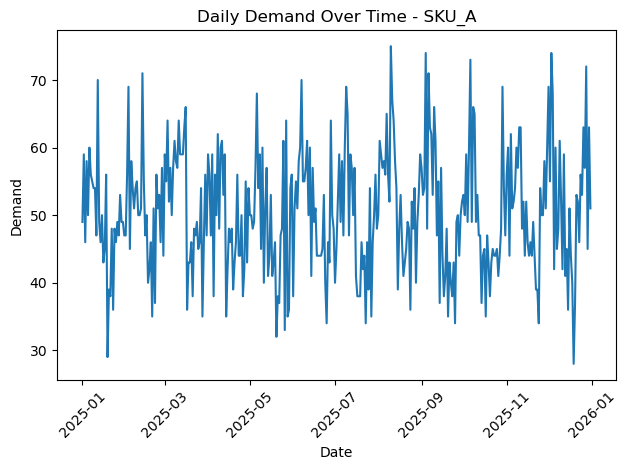

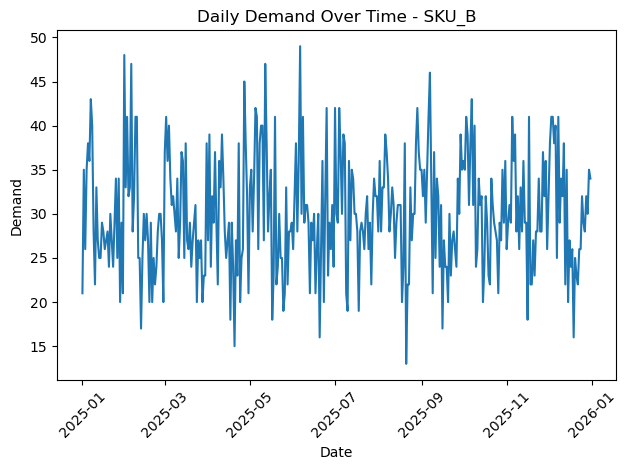

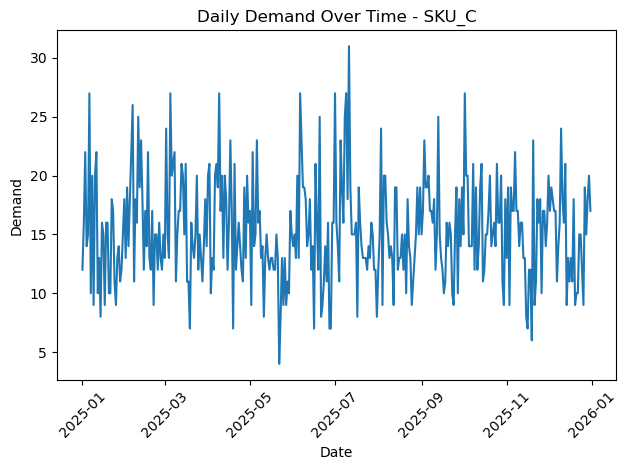

In [25]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"])

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]
    plt.figure()
    plt.plot(tmp["date"], tmp["demand"])
    plt.title(f"Daily Demand Over Time - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


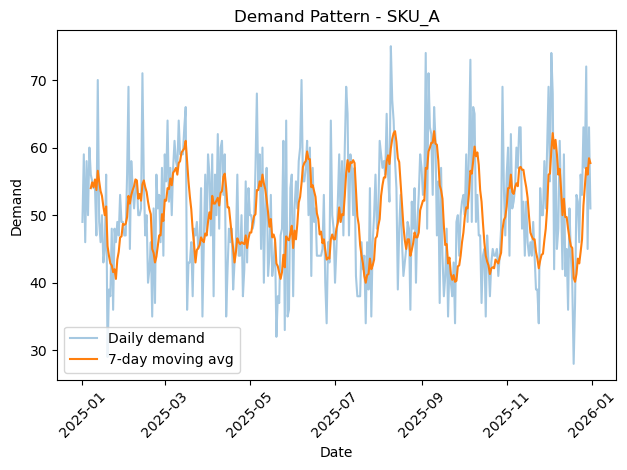

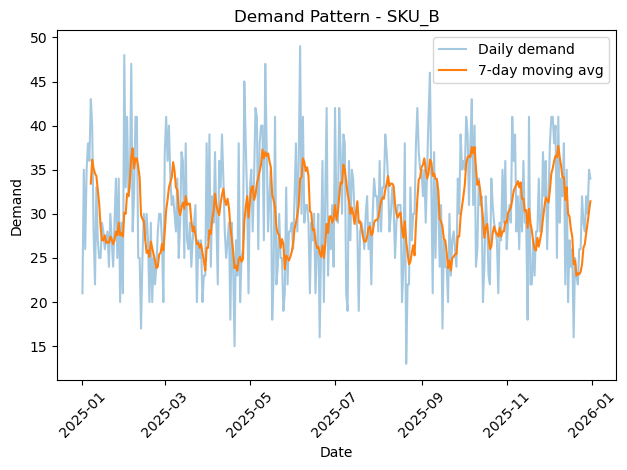

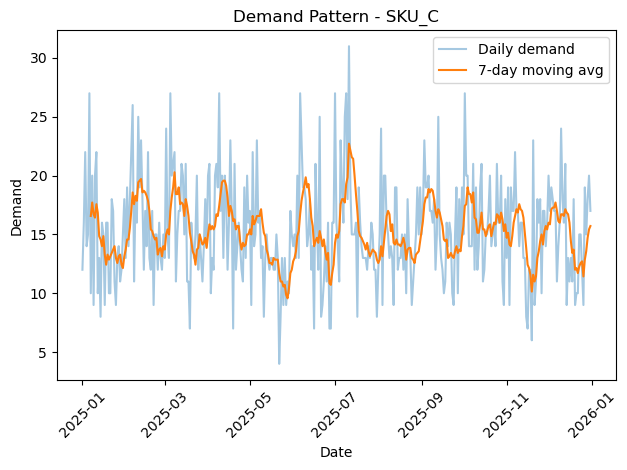

In [26]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"]).copy()
df_plot["demand_ma7"] = df_plot.groupby("sku")["demand"].transform(lambda s: s.rolling(7).mean())

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]
    plt.figure()
    plt.plot(tmp["date"], tmp["demand"], alpha=0.4, label="Daily demand")
    plt.plot(tmp["date"], tmp["demand_ma7"], label="7-day moving avg")
    plt.title(f"Demand Pattern - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


### 6.3 Inventory Behavior Over Time (Inventory Level + Stockouts)
Visualize inventory level trends per SKU to identify understocking periods and stockout events.


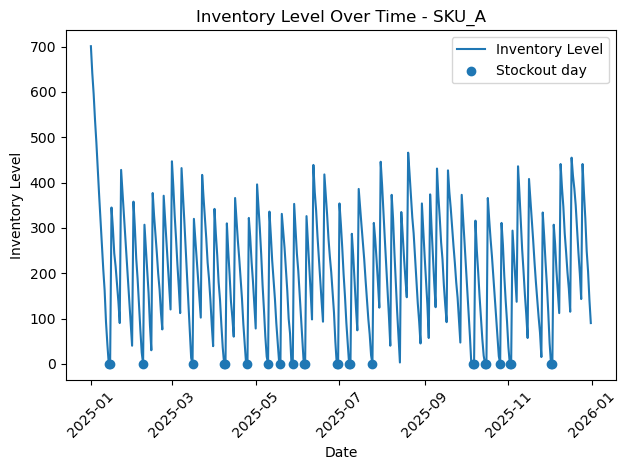

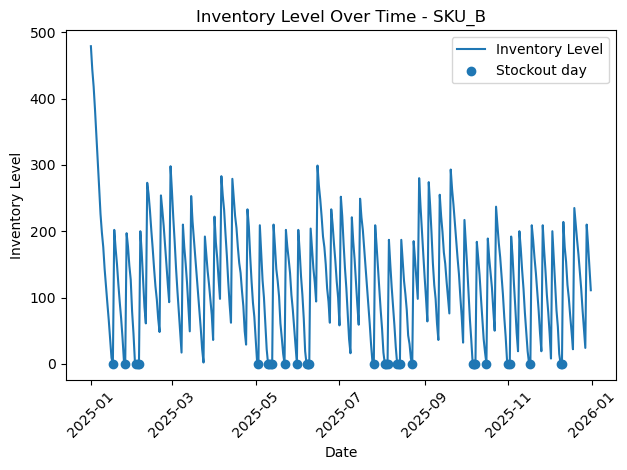

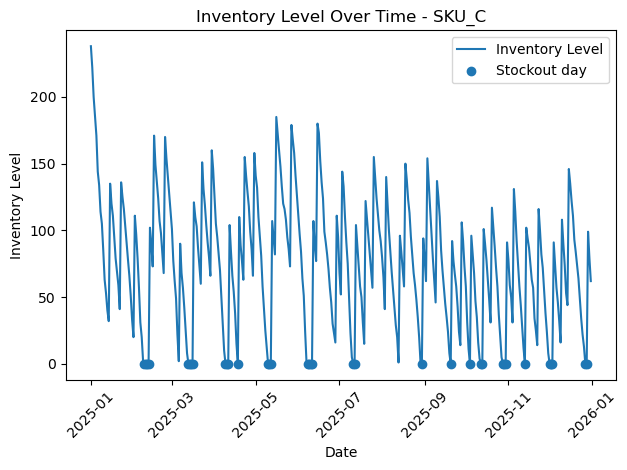

In [27]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"]).copy()

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]

    plt.figure()
    plt.plot(tmp["date"], tmp["inventory_level"], label="Inventory Level")

    # highlight stockout days
    stockout_days = tmp[tmp["stockout"] == 1]
    plt.scatter(stockout_days["date"], stockout_days["inventory_level"], label="Stockout day")

    plt.title(f"Inventory Level Over Time - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


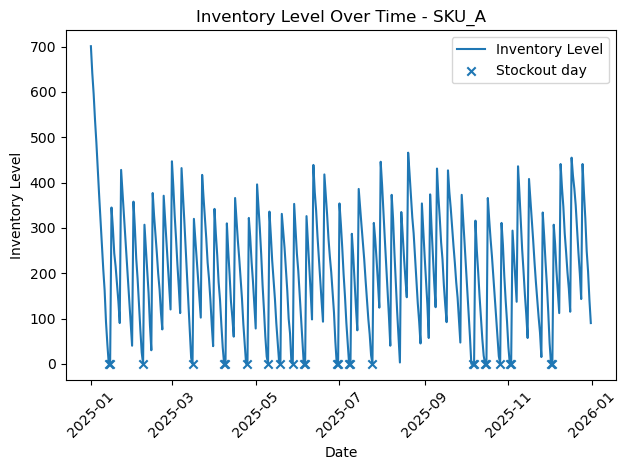

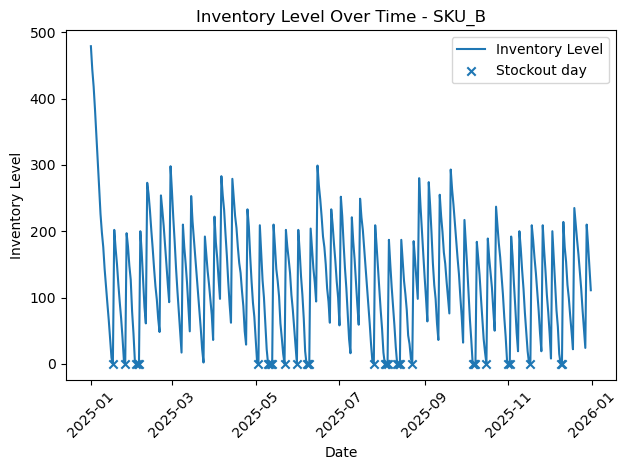

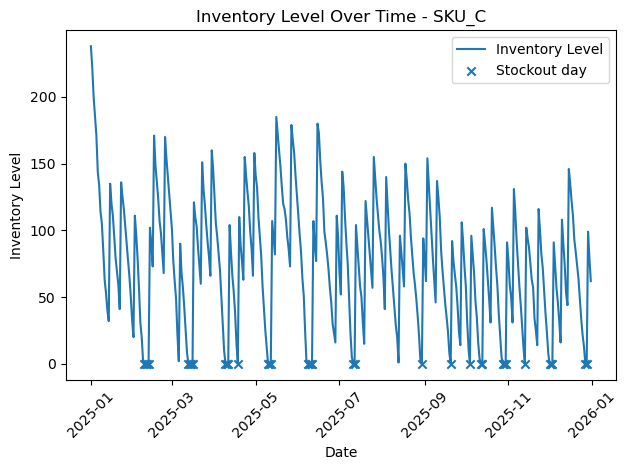

In [28]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"]).copy()

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]

    plt.figure()
    plt.plot(tmp["date"], tmp["inventory_level"], label="Inventory Level")

    stockout_days = tmp[tmp["stockout"] == 1]
    plt.scatter(
        stockout_days["date"],
        stockout_days["inventory_level"],
        label="Stockout day",
        marker="x"
    )

    plt.title(f"Inventory Level Over Time - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


### 6.4 Replenishment Behavior (Orders and Receipts)
This section shows the relationship between inventory level, replenishment ordering, and receipts over time.


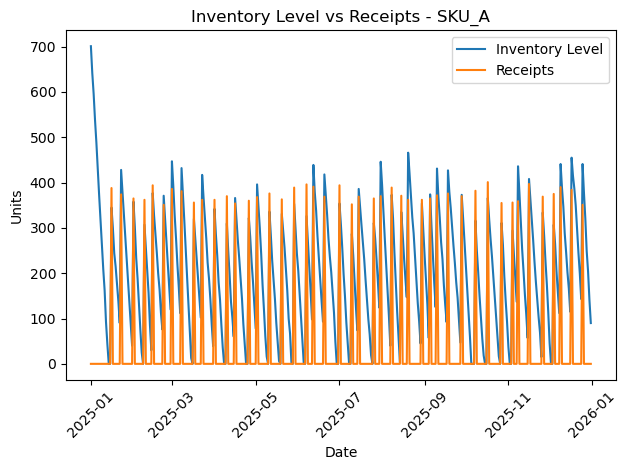

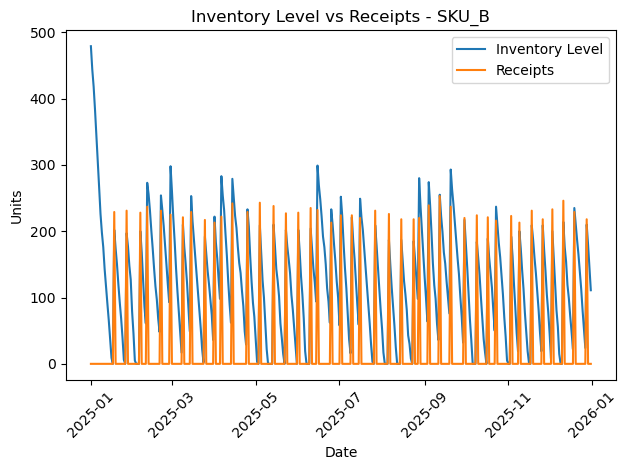

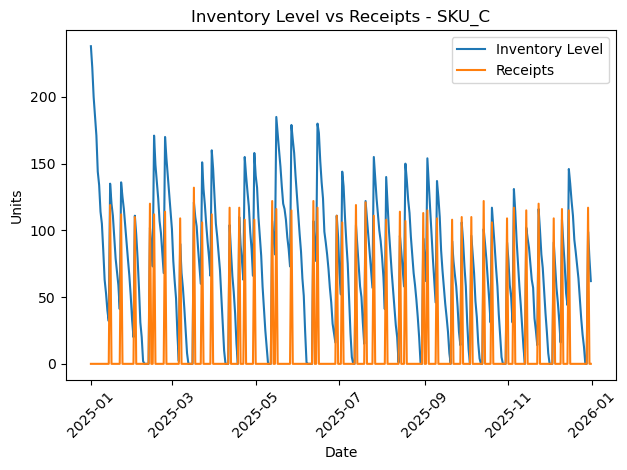

In [29]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"]).copy()

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]

    plt.figure()
    plt.plot(tmp["date"], tmp["inventory_level"], label="Inventory Level")
    plt.plot(tmp["date"], tmp["receipts"], label="Receipts")

    plt.title(f"Inventory Level vs Receipts - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


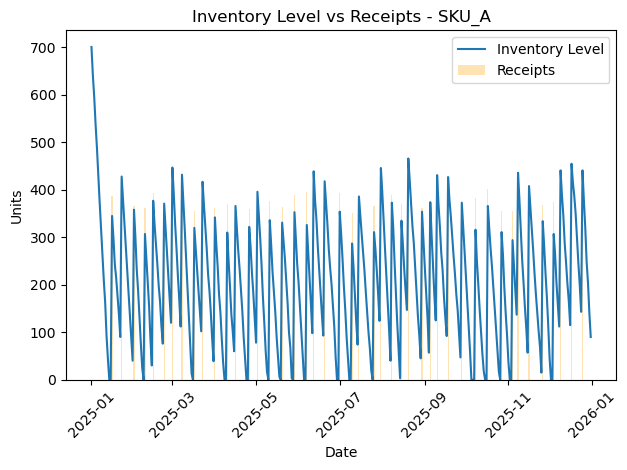

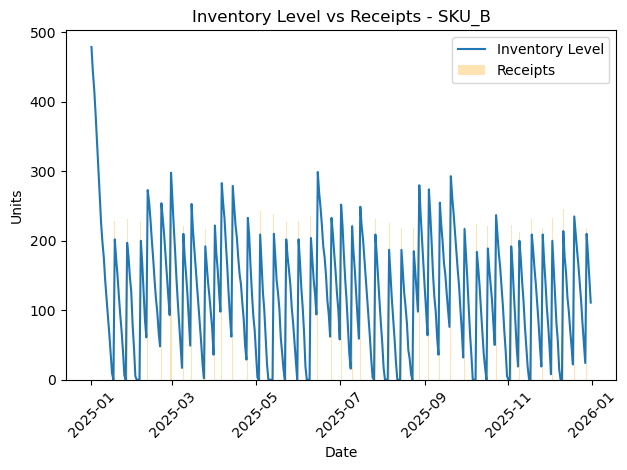

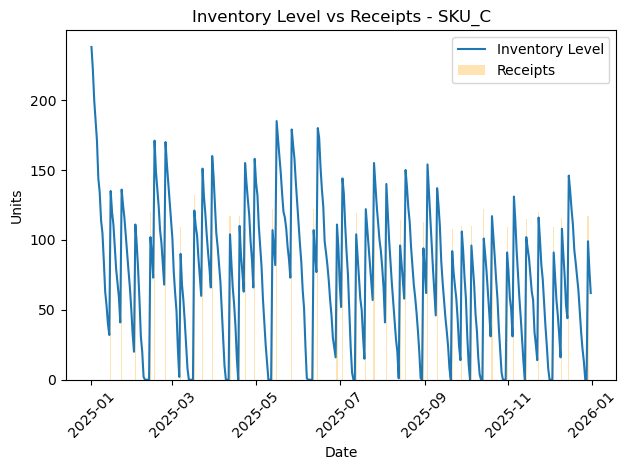

In [30]:
import matplotlib.pyplot as plt

df_plot = df.sort_values(["sku", "date"]).copy()

for sku in df_plot["sku"].unique():
    tmp = df_plot[df_plot["sku"] == sku]

    plt.figure()
    plt.plot(tmp["date"], tmp["inventory_level"], label="Inventory Level")
    plt.bar(tmp["date"], tmp["receipts"], label="Receipts", alpha=0.3, color="orange")

    plt.title(f"Inventory Level vs Receipts - {sku}")
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


### 6.5 Stockouts and Lost Sales (Service Impact)
Summarize how often stockouts occur and how much demand is lost due to insufficient inventory.


In [31]:
service_impact = df.groupby(["sku", "category"]).agg(
    total_demand=("demand", "sum"),
    total_filled=("filled_demand", "sum"),
    total_lost_sales=("lost_sales", "sum"),
    stockout_days=("stockout", "sum")
).reset_index()

service_impact["fill_rate"] = service_impact["total_filled"] / service_impact["total_demand"]
service_impact


,sku,category,total_demand,total_filled,total_lost_sales,stockout_days,fill_rate
0,SKU_A,Fast Movers,18379,17413,966,26,0.947440
1,SKU_B,Medium Movers,10957,10161,796,32,0.927352
2,SKU_C,Slow Movers,5590,5084,506,35,0.909481


## 7. Warehouse KPIs (Summary)
This section consolidates key warehouse performance metrics per SKU for decision-making.


### 7.1 KPI summary table per SKU

Provide summary per SKUs by fill-rate and stockout-rate

In [32]:
kpi = df.groupby(["sku", "category"]).agg(
    days=("date", "nunique"),
    total_demand=("demand", "sum"),
    filled_demand=("filled_demand", "sum"),
    lost_sales=("lost_sales", "sum"),
    stockout_days=("stockout", "sum"),
    avg_inventory=("inventory_level", "mean"),
    min_inventory=("inventory_level", "min"),
    avg_receipts=("receipts", "mean"),
    total_orders=("order_qty", lambda x: (x > 0).sum())
).reset_index()

kpi["fill_rate"] = kpi["filled_demand"] / kpi["total_demand"]
kpi["stockout_rate"] = kpi["stockout_days"] / kpi["days"]

kpi.sort_values("fill_rate", ascending=False)


,sku,category,days,total_demand,filled_demand,lost_sales,stockout_days,avg_inventory,min_inventory,avg_receipts,total_orders,fill_rate,stockout_rate
0,SKU_A,Fast Movers,365,18379,17413,966,26,207.931507,0,45.898630,46,0.947440,0.071233
1,SKU_B,Medium Movers,365,10957,10161,796,32,125.273973,0,26.772603,44,0.927352,0.087671
2,SKU_C,Slow Movers,365,5590,5084,506,35,74.816438,0,13.413699,44,0.909481,0.095890


### 7.2 Cost / Value Impact (Lost Sales Value and Inventory Value)

Translate unit-based KPIs into monetary impact to support decision-making.


In [33]:
# uses derived columns from Section 2.5 (lost_sales_value, inventory_value)
# df["lost_sales_value"] = df["lost_sales"] * df["unit_cost"]
# df["inventory_value"] = df["inventory_level"] * df["unit_cost"]

value_kpi = df.groupby(["sku", "category"]).agg(
    lost_sales_units=("lost_sales", "sum"),
    lost_sales_value=("lost_sales_value", "sum"),
    avg_inventory_value=("inventory_value", "mean")
).reset_index()

value_kpi["lost_sales_value"] = value_kpi["lost_sales_value"].round(2)
value_kpi["avg_inventory_value"] = value_kpi["avg_inventory_value"].round(2)

value_kpi


,sku,category,lost_sales_units,lost_sales_value,avg_inventory_value
0,SKU_A,Fast Movers,966,24150.0,5198.29
1,SKU_B,Medium Movers,796,59700.0,9395.55
2,SKU_C,Slow Movers,506,63250.0,9352.05


## 8. Key Insights (Business Interpretation)

- SKU_A has the highest demand volume and the best service level (highest fill rate), but still experiences stockouts, indicating sensitivity to lead time variability.
- SKU_C has the lowest demand volume, but the highest lost sales value, meaning stockouts on expensive items can create disproportionate business impact.
- Stockout days occur across all SKUs, suggesting the baseline reorder policy is not sufficient to fully absorb demand variability and lead time uncertainty.
- Replenishment receipts clearly drive inventory recovery (saw-tooth pattern), supporting that the simulation reflects realistic warehouse behavior.


## 9. Recommendations (Next Actions)

- Review baseline reorder parameters (reorder point and order-up-to level) per SKU, because stockouts still occur under demand and lead time variability.
- Prioritize improvement efforts based on business impact: SKUs with higher lost sales value should receive higher service protection (e.g., higher safety stock or faster replenishment).
- Quantify trade-offs between service level and inventory investment by testing alternative inventory policies (scenario-based evaluation).

These actions will be implemented in Project 2 (Inventory Optimization), where we compare inventory policy scenarios and select an improved policy based on service level and cost/value impact.
